### Setup and Imports

In [24]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# --- CONFIGURATION ---
# Define paths relative to the current notebook
# Assumes folder structure: project/notebooks/this_file.ipynb
BASE_DIR = os.path.dirname(os.path.abspath("__file__")) # Getting current directory
RAW_DATA_PATH = os.path.join(BASE_DIR, '../data_raw/Shanghai_T1DM')
PROCESSED_DATA_PATH = os.path.join(BASE_DIR, '../data_processed/Shanghai_Processed_NB.csv')
MODEL_PATH_FP32 = os.path.join(BASE_DIR, '../models/tabm_float32_nb.pth')
MODEL_PATH_FP16 = os.path.join(BASE_DIR, '../models/tabm_fp16_nb.pth')

# Hyperparameters
INPUT_WINDOW = 3      # Look back 3 steps (45 mins)
PREDICT_STEPS = 1     # Predict 1 step ahead (15 mins)
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 20

# Ensure output directories exist
os.makedirs(os.path.dirname(PROCESSED_DATA_PATH), exist_ok=True)
os.makedirs(os.path.dirname(MODEL_PATH_FP32), exist_ok=True)

print("System Ready. Computation Device:", "cuda" if torch.cuda.is_available() else "cpu")

System Ready. Computation Device: cpu


## Dataset Characteristics: Invasive vs. Non-Invasive
**Dataset Used**: Shanghai T1DM (Type 1 Diabetes Mellitus).<br>
**Sensor Technology**: Continuous Glucose Monitoring (CGM).

**Classification: Minimally Invasive.**

**Analysis**: The Shanghai dataset relies on CGM data (likely Abbott Libre or Dexcom, common in 2021 studies). These devices use a tiny filament sensor inserted just under the skin (subcutaneous tissue) to measure interstitial fluid glucose.

### EDA

In [25]:
print(f"Current Working Directory: {os.getcwd()}")
print(f"Looking for data in: {RAW_DATA_PATH}")

# check what is actually inside that folder
if os.path.exists(RAW_DATA_PATH):
    files_inside = os.listdir(RAW_DATA_PATH)
    print(f"\nTotal items in folder: {len(files_inside)}")
    print("First 10 items found:")
    print(files_inside[:10])
    
    # Check specifically for excel files
    xls_count = len(glob.glob(f"{RAW_DATA_PATH}/*.xlsx"))
    csv_count = len(glob.glob(f"{RAW_DATA_PATH}/*.csv"))
    print(f"\n.xls files found: {xls_count}")
    print(f".csv files found:  {csv_count}")
else:
    print("\nCRITICAL ERROR: The folder path does not exist!")

Current Working Directory: i:\Diabetes_Early_Detection\notebooks
Looking for data in: i:\Diabetes_Early_Detection\notebooks\../data_raw/Shanghai_T1DM

Total items in folder: 19
First 10 items found:
['1001_0_20210730.xlsx', '1002_0_20210504.xls', '1002_1_20210521.xls', '1002_2_20210909.xls', '1003_0_20210831.xls', '1004_0_20210425.xls', '1005_0_20210522.xls', '1006_0_20210114.xlsx', '1006_1_20210209.xlsx', '1006_2_20210303.xlsx']

.xls files found: 7
.csv files found:  0


--- COMPREHENSIVE CLINICAL DATA ANALYSIS (Dual Event) ---
Found 19 files total.
Processing 16 valid patient files...

       GLOBAL DATASET SUMMARY
Total Patients:        12
Total Sensor Samples:  15,695
Global Mean Glucose:   164.75 mg/dL
----------------------------------------
Normal Range (70-180): 8416 (53.62%)
Hyperglycemia (>180):  6079 (38.73%)
Hypoglycemia (<70):    1200 (7.65%)

INDIVIDUAL PATIENT STATISTICS:


,Patient ID,Total Readings,Mean Glucose (mg/dL),Hypo Events (<70),Hypo Ratio (%),Hyper Events (>180),Hyper Ratio (%)
6,1007,1337,102.80,266,19.90,82,6.13
1,1002,2238,123.62,341,14.97,306,12.68
4,1005,1256,177.47,169,13.46,614,48.89
10,1011,536,146.67,64,11.94,154,28.73
5,1006,3710,186.93,203,5.37,1953,52.78
2,1003,1339,151.02,69,5.15,369,27.56
11,1012,1339,177.81,49,3.66,630,47.05
7,1008,766,185.22,18,2.35,373,48.69
9,1010,918,190.49,13,1.42,504,54.90
0,1001,658,196.83,5,0.76,401,60.94


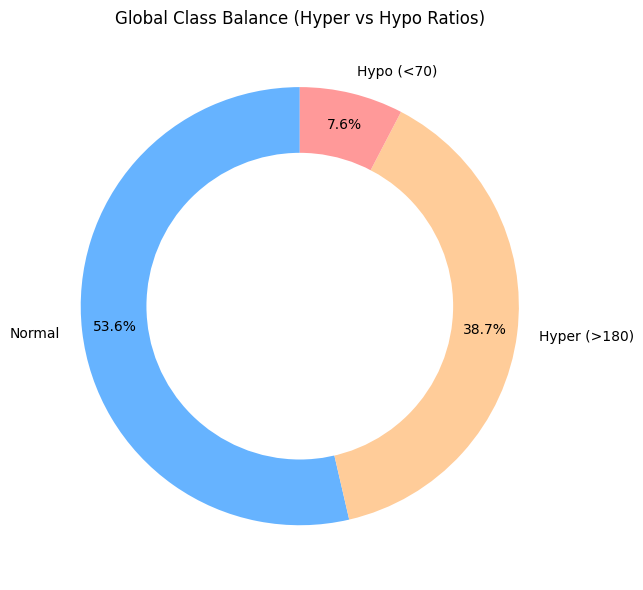

In [26]:
import seaborn as sns

def generate_detailed_clinical_eda():
    print("--- COMPREHENSIVE CLINICAL DATA ANALYSIS (Dual Event) ---")
    
    # 1. Setup: Look for .csv, .xlsx AND .xls (Old Excel)
    all_files = (glob.glob(f"{RAW_DATA_PATH}/*.csv") + 
                 glob.glob(f"{RAW_DATA_PATH}/*.xlsx") + 
                 glob.glob(f"{RAW_DATA_PATH}/*.xls"))
    
    patient_stats = []
    all_glucose_readings = [] 
    
    # Filter out temporary Excel lock files
    valid_files = [f for f in all_files if not os.path.basename(f).startswith('~$')]
    
    print(f"Found {len(all_files)} files total.")
    print(f"Processing {len(valid_files)} valid patient files...")
    
    # 2. Loop through VALID files
    for filepath in valid_files:
        try:
            # Load Data
            if filepath.endswith('.csv'): df = pd.read_csv(filepath)
            else: df = pd.read_excel(filepath)
            
            pid = os.path.basename(filepath).split('_')[0]
            
            # Get Glucose Column
            cgm_col = [c for c in df.columns if 'CGM' in c]
            if not cgm_col: continue
            
            # Clean Data
            glucose = pd.to_numeric(df[cgm_col[0]], errors='coerce').dropna()
            
            # Store for Global Calculation
            all_glucose_readings.extend(glucose.tolist())
            
            # --- CALCULATE CLINICAL METRICS ---
            total = len(glucose)
            if total == 0: continue
            
            hypo = (glucose < 70).sum()   # Low count
            hyper = (glucose > 180).sum() # High count
            
            stats = {
                'Patient ID': pid,
                'Total Readings': total,
                'Mean Glucose (mg/dL)': round(glucose.mean(), 2),
                'Std Dev': round(glucose.std(), 2),
                'Hypo Events (<70)': hypo,
                'Hypo Ratio (%)': round((hypo/total)*100, 2),
                'Hyper Events (>180)': hyper,                 # <--- Added to Dictionary
                'Hyper Ratio (%)': round((hyper/total)*100, 2)# <--- Added to Dictionary
            }
            patient_stats.append(stats)
            
        except Exception as e:
            print(f"Error reading {os.path.basename(filepath)}: {e}")

    # 3. Create DataFrames
    if not patient_stats:
        print("No valid data found.")
        return

    df_patients = pd.DataFrame(patient_stats)
    
    # --- AGGREGATION FIX ---
    # Now we include the Hyper columns in the groupby logic
    df_patients = df_patients.groupby('Patient ID').agg({
        'Total Readings': 'sum',
        'Mean Glucose (mg/dL)': 'mean',
        'Hypo Events (<70)': 'sum',
        'Hypo Ratio (%)': 'mean',
        'Hyper Events (>180)': 'sum',  # <--- NEW: Sum of high events
        'Hyper Ratio (%)': 'mean'      # <--- NEW: Average high ratio
    }).reset_index()

    df_global = pd.DataFrame({'Glucose': all_glucose_readings})
    
    # --- OUTPUT 1: TEXT BASED STATISTICS (GLOBAL) ---
    print("\n" + "="*40)
    print("       GLOBAL DATASET SUMMARY")
    print("="*40)
    print(f"Total Patients:        {len(df_patients)}")
    print(f"Total Sensor Samples:  {len(df_global):,}")
    print(f"Global Mean Glucose:   {df_global['Glucose'].mean():.2f} mg/dL")
    print("-" * 40)
    
    # Calculate Global Class Balance
    global_hypo = (df_global['Glucose'] < 70).sum()
    global_norm = ((df_global['Glucose'] >= 70) & (df_global['Glucose'] <= 180)).sum()
    global_hyper = (df_global['Glucose'] > 180).sum()
    total_global = len(df_global)
    
    print(f"Normal Range (70-180): {global_norm} ({global_norm/total_global*100:.2f}%)")
    print(f"Hyperglycemia (>180):  {global_hyper} ({global_hyper/total_global*100:.2f}%)")
    print(f"Hypoglycemia (<70):    {global_hypo} ({global_hypo/total_global*100:.2f}%)")
    print("="*40 + "\n")

    # --- OUTPUT 2: INDIVIDUAL PATIENT TABLE ---
    print("INDIVIDUAL PATIENT STATISTICS:")
    # We format the float columns to look cleaner
    pd.options.display.float_format = '{:.2f}'.format
    display(df_patients.sort_values(by='Hypo Ratio (%)', ascending=False))
    
    # --- OUTPUT 3: VISUALIZATIONS ---
    plt.figure(figsize=(14, 6))
    
    # Plot B: Donut Chart
    plt.subplot(1, 1, 1) # Full width for clarity
    labels = ['Normal', 'Hyper (>180)', 'Hypo (<70)']
    sizes = [global_norm, global_hyper, global_hypo]
    colors = ['#66b3ff', '#ffcc99', '#ff9999'] 
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
    
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    
    plt.title("Global Class Balance (Hyper vs Hypo Ratios)")
    plt.tight_layout()
    plt.show()

generate_detailed_clinical_eda()


--- PART 2: SENSOR DATA QUALITY (EDA) ---
Inspecting Sample File: 1001_0_20210730.xlsx
Total Readings: 658
Missing/Corrupt Glucose Readings: 0 (0.00%)


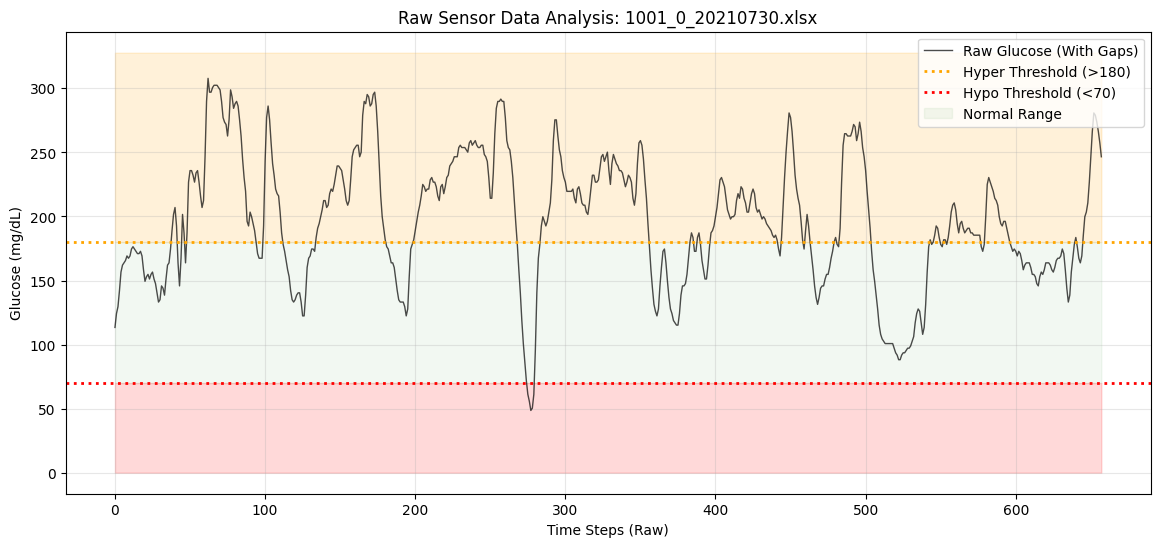

In [27]:
def perform_sensor_eda():
    print("\n--- PART 2: SENSOR DATA QUALITY (EDA) ---")
    
    # 1. Load just ONE random patient file to inspect
    all_files = glob.glob(f"{RAW_DATA_PATH}/*.csv") + glob.glob(f"{RAW_DATA_PATH}/*.xlsx") + glob.glob(f"{RAW_DATA_PATH}/*.xls")
    
    # Filter out temp files
    valid_files = [f for f in all_files if not os.path.basename(f).startswith('~$')]
    
    if not valid_files:
        print("No files found.")
        return None
        
    sample_file = valid_files[0]
    print(f"Inspecting Sample File: {os.path.basename(sample_file)}")
    
    if sample_file.endswith('.csv'):
        df = pd.read_csv(sample_file)
    else:
        df = pd.read_excel(sample_file)
        
    # Standardize date column for plotting
    if 'Date' in df.columns: df.rename(columns={'Date': 'Timestamp'}, inplace=True)
    
    # 2. Identify Missing Values
    # Find the glucose column (CGM)
    cgm_col = [c for c in df.columns if 'CGM' in c]
    if not cgm_col: return
    cgm_col = cgm_col[0]
    
    # Convert to numeric, forcing errors to NaN
    temp_glucose = pd.to_numeric(df[cgm_col], errors='coerce')
    missing_count = temp_glucose.isna().sum()
    total_rows = len(df)
    missing_perc = (missing_count / total_rows) * 100
    
    print(f"Total Readings: {total_rows}")
    print(f"Missing/Corrupt Glucose Readings: {missing_count} ({missing_perc:.2f}%)")
    
    # 3. Visualize the Gaps with Danger Zones
    plt.figure(figsize=(14, 6))
    
    # Plot the raw line (Black instead of gray for better contrast against colors)
    plt.plot(temp_glucose, label='Raw Glucose (With Gaps)', color='black', linewidth=1, alpha=0.7)
    
    # --- ADD ZONES ---
    # Hyperglycemia (>180) - Orange Zone
    plt.axhline(y=180, color='orange', linestyle=':', linewidth=2, label='Hyper Threshold (>180)')
    # We fill up to the max value found in data + a little buffer
    max_val = temp_glucose.max() if not pd.isna(temp_glucose.max()) else 300
    plt.fill_between(range(len(temp_glucose)), 180, max_val + 20, color='orange', alpha=0.15)
    
    # Hypoglycemia (<70) - Red Zone
    plt.axhline(y=70, color='red', linestyle=':', linewidth=2, label='Hypo Threshold (<70)')
    plt.fill_between(range(len(temp_glucose)), 0, 70, color='red', alpha=0.15)
    
    # Normal Range (Green tint)
    plt.fill_between(range(len(temp_glucose)), 70, 180, color='green', alpha=0.05, label='Normal Range')

    plt.title(f"Raw Sensor Data Analysis: {os.path.basename(sample_file)}")
    plt.xlabel("Time Steps (Raw)")
    plt.ylabel("Glucose (mg/dL)")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return df

# Run Sensor EDA
df_sample_raw = perform_sensor_eda()

### 2. Data Engineering (The Pipeline)

In [28]:
def process_shanghai_data():
    print("--- Step 1: Processing Raw Data ---")
    
    # FIX 1: Add *.xls to the search pattern so we catch the old Excel files
    all_files = glob.glob(f"{RAW_DATA_PATH}/*.csv") + \
                glob.glob(f"{RAW_DATA_PATH}/*.xlsx") + \
                glob.glob(f"{RAW_DATA_PATH}/*.xls")
    
    if not all_files:
        raise FileNotFoundError(f"No files found in {RAW_DATA_PATH}. Please check your folders.")
        
    print(f"Found {len(all_files)} files.")
    master_list = []

    for filepath in all_files:
        try:
            filename = os.path.basename(filepath)
            
            # FIX 2: Skip temporary Excel lock files (files that start with ~$)
            if filename.startswith('~$'):
                continue

            patient_id = filename.split('_')[0]
            
            # 1. Load File
            if filepath.endswith('.csv'):
                df = pd.read_csv(filepath)
            else:
                # FIX 3: pd.read_excel automatically handles .xls if xlrd is installed
                df = pd.read_excel(filepath)

            # 2. Clean Column Names
            if 'Date' in df.columns:
                df.rename(columns={'Date': 'Timestamp'}, inplace=True)
            
            # Find Glucose Column
            cgm_col = [c for c in df.columns if 'CGM' in c]
            if not cgm_col: continue
            cgm_col = cgm_col[0]

            # 3. Clean Values & Interpolate
            df['Glucose'] = pd.to_numeric(df[cgm_col], errors='coerce')
            df['Glucose'] = df['Glucose'].interpolate(method='linear')

            # 4. Resample to 15-minute intervals
            df['Timestamp'] = pd.to_datetime(df['Timestamp'])
            df = df.set_index('Timestamp')
            # 'min' avoids the FutureWarning seen in your screenshot
            df_resampled = df[['Glucose']].resample('15min').mean()
            df_resampled['Glucose'] = df_resampled['Glucose'].interpolate(method='linear')

            # 5. Create Sliding Windows (Lag Features)
            for i in range(1, INPUT_WINDOW + 1):
                df_resampled[f'Glucose_Lag_{i}'] = df_resampled['Glucose'].shift(i)
            
            # Target (t+1)
            df_resampled['Target_Glucose'] = df_resampled['Glucose'].shift(-PREDICT_STEPS)

            # 6. Cleanup
            df_resampled.dropna(inplace=True)
            df_resampled['Patient_ID'] = patient_id
            master_list.append(df_resampled)
            
        except Exception as e:
            print(f"Skipped {filename}: {e}")

    if master_list:
        final_df = pd.concat(master_list)
        final_df.to_csv(PROCESSED_DATA_PATH)
        print(f"Success. Processed data saved to: {PROCESSED_DATA_PATH}")
        print(f"Total Samples: {len(final_df)}")
        print(f"Unique Patients Included: {final_df['Patient_ID'].unique()}")
        return final_df
    else:
        print("Failed to process data.")
        return None

# Run the processing
df = process_shanghai_data()
if df is not None:
    df.head()

--- Step 1: Processing Raw Data ---
Found 19 files.
Success. Processed data saved to: i:\Diabetes_Early_Detection\notebooks\../data_processed/Shanghai_Processed_NB.csv
Total Samples: 15632
Unique Patients Included: ['1001' '1006' '1002' '1003' '1004' '1005' '1007' '1008' '1009' '1010'
 '1011' '1012']


### Imbalance Ratio

--- CHECKING 3-CLASS IMBALANCE (Hypo vs Normal vs Hyper) ---
Total Samples: 15632
1. Normal (70-180):   8387 (53.65%)
2. Hypo (< 70):       1196 (7.65%)  <- Minority Class
3. Hyper (> 180):     6049 (38.70%) <- Usually Majority


C:\Users\Lam\AppData\Local\Temp\ipykernel_10644\1000618007.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Health_State', data=df, palette=['green', 'red', 'orange'])


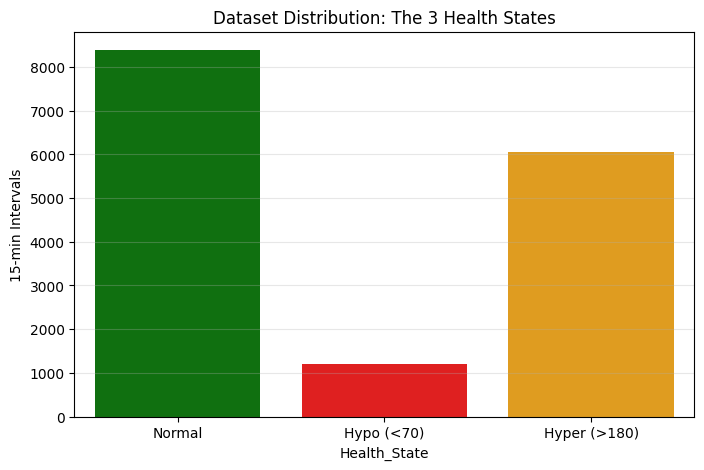

In [29]:
def check_class_imbalance(processed_csv_path):
    print("--- CHECKING 3-CLASS IMBALANCE (Hypo vs Normal vs Hyper) ---")
    df = pd.read_csv(processed_csv_path)
    
    # Define Medical Thresholds
    HYPO_THRESHOLD = 70   # Below 70 is Hypoglycemia (Dangerous Low)
    HYPER_THRESHOLD = 180 # Above 180 is Hyperglycemia (Dangerous High)
    
    # Create Labels
    # 0 = Normal
    # 1 = Hypo
    # 2 = Hyper
    conditions = [
        (df['Target_Glucose'] < HYPO_THRESHOLD),
        (df['Target_Glucose'] > HYPER_THRESHOLD)
    ]
    choices = [1, 2] # 1 for Hypo, 2 for Hyper
    
    # Default is 0 (Normal)
    df['Health_State'] = np.select(conditions, choices, default=0)
    
    # Counts
    counts = df['Health_State'].value_counts().sort_index()
    total = len(df)
    
    # Safe get method in case a class is missing
    norm_count = counts.get(0, 0)
    hypo_count = counts.get(1, 0)
    hyper_count = counts.get(2, 0)
    
    print(f"Total Samples: {total}")
    print(f"1. Normal (70-180):   {norm_count} ({norm_count/total*100:.2f}%)")
    print(f"2. Hypo (< 70):       {hypo_count} ({hypo_count/total*100:.2f}%)  <- Minority Class")
    print(f"3. Hyper (> 180):     {hyper_count} ({hyper_count/total*100:.2f}%) <- Usually Majority")
    
    # Visualization
    plt.figure(figsize=(8, 5))
    sns.countplot(x='Health_State', data=df, palette=['green', 'red', 'orange'])
    plt.xticks([0, 1, 2], ['Normal', 'Hypo (<70)', 'Hyper (>180)'])
    plt.title("Dataset Distribution: The 3 Health States")
    plt.ylabel("15-min Intervals")
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    
    return hypo_count, hyper_count

# Run the check
h_count, H_count = check_class_imbalance(PROCESSED_DATA_PATH)

### 3. Dataset Class

In [30]:
class DiabetesDataset(Dataset):
    def __init__(self, csv_path, patient_ids=None):
        """
        Args:
            csv_path: Path to the processed CSV.
            patient_ids: A list of strings (e.g., ['1001', '1002']). 
                         If provided, ONLY loads data for these patients.
        """
        self.data = pd.read_csv(csv_path)
        
        # --- NEW LOGIC FOR LOSO ---
        # If a specific list of patients is provided, filter the dataframe
        if patient_ids is not None:
            # Ensure patient IDs are strings for comparison
            self.data['Patient_ID'] = self.data['Patient_ID'].astype(str)
            self.data = self.data[self.data['Patient_ID'].isin(patient_ids)]
            
        # Reset index after filtering so __getitem__ works correctly
        self.data = self.data.reset_index(drop=True)
        # --------------------------
        
        # Select Features (Exclude Target, ID, Timestamp)
        feature_cols = [c for c in self.data.columns if c not in ['Target_Glucose', 'Patient_ID', 'Timestamp']]
        
        self.X = self.data[feature_cols].values.astype(np.float32)
        self.y = self.data['Target_Glucose'].values.astype(np.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

print("Dataset Class Updated for LOSO.")

Dataset Class Updated for LOSO.


### 4. TabM Model Architecture

In [31]:
class BatchEnsembleLayer(nn.Module):
    def __init__(self, in_features, out_features, num_models=4):
        super().__init__()
        self.num_models = num_models
        
        # Shared Weight
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        
        # Ensemble Personalities (Alpha) and Votes (Gamma)
        self.alpha = nn.Parameter(torch.Tensor(num_models, in_features))
        self.gamma = nn.Parameter(torch.Tensor(num_models, out_features))
        self.bias = nn.Parameter(torch.Tensor(out_features))
        
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=5**0.5)
        nn.init.normal_(self.alpha, mean=1.0, std=0.1)
        nn.init.normal_(self.gamma, mean=1.0, std=0.1)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        # x shape: (Batch * Num_Models, In_Features)
        total_rows = x.size(0)
        real_batch_size = total_rows // self.num_models
        
        # 1. Align Alpha
        alpha_mask = self.alpha.repeat(real_batch_size, 1)
        x_scaled = x * alpha_mask
        
        # 2. Shared Weight
        result = F.linear(x_scaled, self.weight)
        
        # 3. Align Gamma
        gamma_mask = self.gamma.repeat(real_batch_size, 1)
        result = result * gamma_mask
        
        # 4. Bias
        return result + self.bias

class TabM_Regressor(nn.Module):
    def __init__(self, input_dim, num_models=4):
        super().__init__()
        self.num_models = num_models
        
        # Architecture: Input -> 64 -> 32 -> Output
        self.layer1 = BatchEnsembleLayer(input_dim, 64, num_models)
        self.relu = nn.ReLU()
        self.layer2 = BatchEnsembleLayer(64, 32, num_models)
        
        # Output Head: Combines all models (32 features * 4 models)
        self.output_head = nn.Linear(32 * num_models, 1)

    def forward(self, x):
        batch_size = x.size(0)
        
        # Step 1: Expand Input (Repeat data for each ensemble member)
        x = x.repeat_interleave(self.num_models, dim=0)
        
        # Step 2: Process Layers
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        
        # Step 3: Reshape (Bring expert opinions side-by-side)
        x = x.view(batch_size, -1)
        
        # Step 4: Final Decision
        return self.output_head(x)

print("TabM Architecture Defined.")

TabM Architecture Defined.


### Metric Helper Function

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

def calculate_dual_metrics(y_true_reg, y_pred_reg):
    """
    Evaluates both Hypoglycemia (Low) and Hyperglycemia (High) detection.
    
    Returns a dictionary containing metrics for both conditions.
    """
    # Medical Thresholds
    HYPO_THRESH = 70
    HYPER_THRESH = 180
    
    # Convert tensors to numpy
    if isinstance(y_true_reg, torch.Tensor):
        y_true_reg = y_true_reg.cpu().numpy()
    if isinstance(y_pred_reg, torch.Tensor):
        y_pred_reg = y_pred_reg.cpu().numpy()
        
    # --- BINARIZE INTO 3 CLASSES ---
    # Function to map glucose -> class
    def categorize(glucose_array):
        cats = np.zeros_like(glucose_array, dtype=int) # Default 0 (Normal)
        cats[glucose_array < HYPO_THRESH] = 1          # 1 = Hypo
        cats[glucose_array > HYPER_THRESH] = 2         # 2 = Hyper
        return cats
    
    y_true_class = categorize(y_true_reg)
    y_pred_class = categorize(y_pred_reg)
    
    # --- CALCULATE METRICS ---
    # We use 'average=None' to get scores for each class individually
    
    # 1. Overall Accuracy (Did we get the state right?)
    acc = accuracy_score(y_true_class, y_pred_class)
    
    # 2. Detailed per-class metrics
    # labels=[1, 2] ensures we specifically look at Hypo and Hyper columns
    # zero_division=0 prevents crashes if a patient has 0 attacks
    prec = precision_score(y_true_class, y_pred_class, labels=[1, 2], average=None, zero_division=0)
    rec = recall_score(y_true_class, y_pred_class, labels=[1, 2], average=None, zero_division=0)
    f1 = f1_score(y_true_class, y_pred_class, labels=[1, 2], average=None, zero_division=0)
    
    # Extract specific scores (Index 0 is Hypo, Index 1 is Hyper because of labels=[1, 2])
    results = {
        "Accuracy": acc,
        
        "Hypo_Precision": prec[0],
        "Hypo_Recall": rec[0],
        "Hypo_F1": f1[0],
        
        "Hyper_Precision": prec[1],
        "Hyper_Recall": rec[1],
        "Hyper_F1": f1[1]
    }
    
    return results

### LOSO Cross Validation and Training Loop

In [33]:
# FORCE UPDATE THE PATH
# Ensure this matches exactly where the processing step saved the file
PROCESSED_DATA_PATH = os.path.join(BASE_DIR, '../data_processed/Shanghai_Processed_NB.csv')

print(f"Targeting Data File: {PROCESSED_DATA_PATH}")

# Check if the file actually has 12 patients on disk
check_df = pd.read_csv(PROCESSED_DATA_PATH)
# Ensure Patient_ID is read as string
check_df['Patient_ID'] = check_df['Patient_ID'].astype(str)
patients_on_disk = check_df['Patient_ID'].unique()

print(f"Patients confirmed on disk: {len(patients_on_disk)}")
print(patients_on_disk)

Targeting Data File: i:\Diabetes_Early_Detection\notebooks\../data_processed/Shanghai_Processed_NB.csv
Patients confirmed on disk: 12
['1001' '1006' '1002' '1003' '1004' '1005' '1007' '1008' '1009' '1010'
 '1011' '1012']


In [34]:
def run_loso_experiment():
    print("--- STARTING LOSO CROSS-VALIDATION (Dual-Detection: Hypo & Hyper) ---")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 1. Identify Patients
    full_df = pd.read_csv(PROCESSED_DATA_PATH)
    full_df['Patient_ID'] = full_df['Patient_ID'].astype(str) 
    patient_list = full_df['Patient_ID'].unique().tolist()
    
    print(f"Patients found ({len(patient_list)}): {patient_list}")
    
    if len(patient_list) < 2:
        print("ERROR: Need at least 2 patients.")
        return None

    results_log = []
    
    # LOOP: Test on each patient
    for test_subject in patient_list:
        print(f"\n[Testing Subject: {test_subject}]")
        
        # Split Logic
        others = [p for p in patient_list if p != test_subject]
        
        if len(others) < 2:
            train_subjects = others
            val_subjects = others
        else:
            split_point = int(0.75 * len(others))
            if split_point == 0: split_point = 1 
            train_subjects = others[:split_point]
            val_subjects = others[split_point:]
        
        # Datasets
        train_ds = DiabetesDataset(PROCESSED_DATA_PATH, patient_ids=train_subjects)
        val_ds = DiabetesDataset(PROCESSED_DATA_PATH, patient_ids=val_subjects)
        test_ds = DiabetesDataset(PROCESSED_DATA_PATH, patient_ids=[test_subject])
        
        if len(train_ds) == 0: continue

        # DataLoaders
        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
        test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
        
        # Init Model
        sample_in, _ = train_ds[0]
        model = TabM_Regressor(input_dim=sample_in.shape[0], num_models=4).to(device)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        criterion = nn.MSELoss()
        
        # --- TRAINING LOOP ---
        for epoch in range(20): # Keep at 5 for quick testing, 20 for final
            model.train()
            for x, y in train_loader:
                x, y = x.to(device), y.to(device).view(-1, 1)
                optimizer.zero_grad()
                loss = criterion(model(x), y)
                loss.backward()
                optimizer.step()
                
        # --- TESTING ---
        model.eval()
        all_preds, all_targets = [], []
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device).view(-1, 1)
                preds = model(x)
                all_preds.append(preds)
                all_targets.append(y)
        
        if len(all_preds) > 0:
            y_pred = torch.cat(all_preds)
            y_true = torch.cat(all_targets)
            
            # 1. Standard Regression Metric
            rmse = np.sqrt(criterion(y_pred, y_true).item())
            
            # 2. NEW: Dual Classification Metrics
            metrics = calculate_dual_metrics(y_true, y_pred)
            
            print(f"   -> RMSE: {rmse:.2f}")
            print(f"      [Hypo] Recall: {metrics['Hypo_Recall']:.2f} | F1: {metrics['Hypo_F1']:.2f}")
            print(f"      [Hyper] Recall: {metrics['Hyper_Recall']:.2f} | F1: {metrics['Hyper_F1']:.2f}")
            
            # Log everything for the final table
            log_entry = {
                "Subject": test_subject,
                "RMSE": rmse,
                "Accuracy": metrics['Accuracy'],
                # Hypo (Low)
                "Hypo_Prec": metrics['Hypo_Precision'],
                "Hypo_Rec": metrics['Hypo_Recall'],
                "Hypo_F1": metrics['Hypo_F1'],
                # Hyper (High)
                "Hyper_Prec": metrics['Hyper_Precision'],
                "Hyper_Rec": metrics['Hyper_Recall'],
                "Hyper_F1": metrics['Hyper_F1']
            }
            results_log.append(log_entry)
            
            torch.save(model.state_dict(), MODEL_PATH_FP32)

    # Generate Results
    if results_log:
        df_res = pd.DataFrame(results_log)
        print("\n--- LOSO DUAL-DETECTION RESULTS ---")
        # Show just the key columns to keep it readable
        display(df_res[['Subject', 'RMSE', 'Hypo_Rec', 'Hypo_F1', 'Hyper_Rec', 'Hyper_F1']])
        
        print("\n--- GLOBAL AVERAGES ---")
        print(df_res.mean(numeric_only=True))
        return df_res

# EXECUTE
loso_results = run_loso_experiment()

--- STARTING LOSO CROSS-VALIDATION (Dual-Detection: Hypo & Hyper) ---
Patients found (12): ['1001', '1006', '1002', '1003', '1004', '1005', '1007', '1008', '1009', '1010', '1011', '1012']

[Testing Subject: 1001]
   -> RMSE: 6.60
      [Hypo] Recall: 1.00 | F1: 1.00
      [Hyper] Recall: 0.97 | F1: 0.97

[Testing Subject: 1006]
   -> RMSE: 6.48
      [Hypo] Recall: 0.89 | F1: 0.85
      [Hyper] Recall: 0.99 | F1: 0.99

[Testing Subject: 1002]
   -> RMSE: 5.11
      [Hypo] Recall: 0.93 | F1: 0.93
      [Hyper] Recall: 0.93 | F1: 0.94

[Testing Subject: 1003]
   -> RMSE: 6.16
      [Hypo] Recall: 0.96 | F1: 0.94
      [Hyper] Recall: 0.97 | F1: 0.97

[Testing Subject: 1004]
   -> RMSE: 7.16
      [Hypo] Recall: 1.00 | F1: 0.50
      [Hyper] Recall: 0.96 | F1: 0.97

[Testing Subject: 1005]
   -> RMSE: 7.50
      [Hypo] Recall: 0.94 | F1: 0.94
      [Hyper] Recall: 0.98 | F1: 0.97

[Testing Subject: 1007]
   -> RMSE: 5.78
      [Hypo] Recall: 0.92 | F1: 0.91
      [Hyper] Recall: 0.93 | F1

,Subject,RMSE,Hypo_Rec,Hypo_F1,Hyper_Rec,Hyper_F1
0,1001,6.60,1.00,1.00,0.97,0.97
1,1006,6.48,0.89,0.85,0.99,0.99
2,1002,5.11,0.93,0.93,0.93,0.94
3,1003,6.16,0.96,0.94,0.97,0.97
4,1004,7.16,1.00,0.50,0.96,0.97
5,1005,7.50,0.94,0.94,0.98,0.97
6,1007,5.78,0.92,0.91,0.93,0.91
7,1008,6.38,0.72,0.81,0.98,0.97
8,1009,6.57,0.50,0.67,0.95,0.95
9,1010,6.19,0.85,0.85,0.99,0.98



--- GLOBAL AVERAGES ---
RMSE         6.72
Accuracy     0.96
Hypo_Prec    0.85
Hypo_Rec     0.89
Hypo_F1      0.84
Hyper_Prec   0.96
Hyper_Rec    0.96
Hyper_F1     0.96
dtype: float64


### Training Dynamics


--- PART 3.5: TRAINING DYNAMICS (Hypo vs Hyper Learning Curves) ---
Training Cohort: 9 patients | Validation Cohort: 3 patients
Training representative model for 20 Epochs...
Epoch 5: MSE 55.2 | Hypo Recall 0.94 | Hyper Recall 0.97
Epoch 10: MSE 46.2 | Hypo Recall 0.90 | Hyper Recall 0.98
Epoch 15: MSE 43.3 | Hypo Recall 0.94 | Hyper Recall 0.98
Epoch 20: MSE 41.9 | Hypo Recall 0.95 | Hyper Recall 0.97


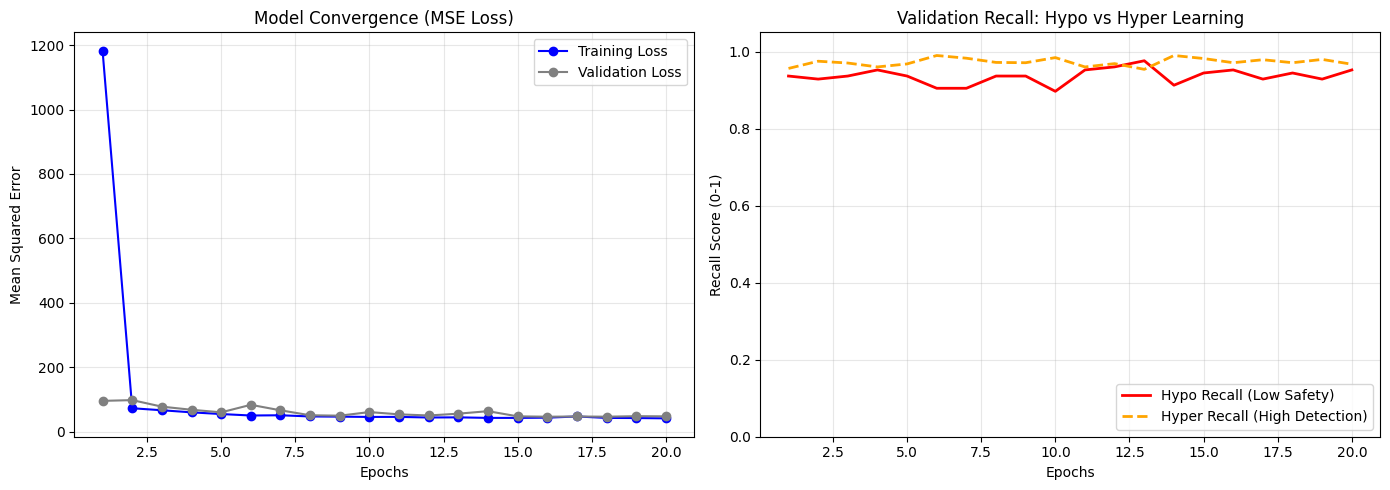

In [35]:
def plot_training_dynamics():
    print("\n--- PART 3.5: TRAINING DYNAMICS (Hypo vs Hyper Learning Curves) ---")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 1. Setup Representative Split (Same as before)
    full_df = pd.read_csv(PROCESSED_DATA_PATH)
    full_df['Patient_ID'] = full_df['Patient_ID'].astype(str)
    all_patients = full_df['Patient_ID'].unique().tolist()
    
    # Use first 80% for train, last 20% for val
    split_idx = int(0.8 * len(all_patients))
    train_patients = all_patients[:split_idx]
    val_patients = all_patients[split_idx:]
    
    print(f"Training Cohort: {len(train_patients)} patients | Validation Cohort: {len(val_patients)} patients")
    
    train_ds = DiabetesDataset(PROCESSED_DATA_PATH, patient_ids=train_patients)
    val_ds = DiabetesDataset(PROCESSED_DATA_PATH, patient_ids=val_patients)
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    
    # 2. Init Model
    sample_in, _ = train_ds[0]
    model = TabM_Regressor(input_dim=sample_in.shape[0], num_models=4).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()
    
    # 3. NEW STORAGE STRUCTURE
    # We track both conditions separately
    history = {
        'train_loss': [], 
        'val_loss': [],
        'hypo_recall': [], 
        'hyper_recall': []
    }
    
    # 4. Run 20 Epochs
    print("Training representative model for 20 Epochs...")
    for epoch in range(20):
        # -- TRAIN --
        model.train()
        train_loss_accum = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device).view(-1, 1)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()
            train_loss_accum += loss.item()
            
        avg_train_loss = train_loss_accum / len(train_loader)
        
        # -- VALIDATION --
        model.eval()
        val_loss_accum = 0
        all_preds, all_targets = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device).view(-1, 1)
                preds = model(x)
                val_loss_accum += criterion(preds, y).item()
                all_preds.append(preds)
                all_targets.append(y)
        
        avg_val_loss = val_loss_accum / len(val_loader)
        
        # Calculate DUAL Metrics
        y_p = torch.cat(all_preds)
        y_t = torch.cat(all_targets)
        
        # Use the NEW dictionary-based metric function
        metrics = calculate_dual_metrics(y_t, y_p)
        
        # Store
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['hypo_recall'].append(metrics['Hypo_Recall'])
        history['hyper_recall'].append(metrics['Hyper_Recall'])
        
        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}: MSE {avg_train_loss:.1f} | Hypo Recall {metrics['Hypo_Recall']:.2f} | Hyper Recall {metrics['Hyper_Recall']:.2f}")

    # 5. PLOTTING (Updated for Dual Detection)
    epochs_range = range(1, 21)
    plt.figure(figsize=(14, 5))
    
    # Graph 1: Loss Curve (MSE)
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['train_loss'], label='Training Loss', marker='o', color='blue')
    plt.plot(epochs_range, history['val_loss'], label='Validation Loss', marker='o', color='gray')
    plt.title("Model Convergence (MSE Loss)")
    plt.xlabel("Epochs")
    plt.ylabel("Mean Squared Error")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Graph 2: Dual Detection Recall
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['hypo_recall'], label='Hypo Recall (Low Safety)', color='red', linestyle='-', linewidth=2)
    plt.plot(epochs_range, history['hyper_recall'], label='Hyper Recall (High Detection)', color='orange', linestyle='--', linewidth=2)
    plt.title("Validation Recall: Hypo vs Hyper Learning")
    plt.xlabel("Epochs")
    plt.ylabel("Recall Score (0-1)")
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1.05) # Fix y-axis to show 0-100% clearly
    
    plt.tight_layout()
    plt.show()

plot_training_dynamics()

### 6. Quantization

In [36]:
def run_ablation_study():
    print("\n--- PART 4: ABLATION & OPTIMIZATION STUDY (Dual Metrics) ---")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 1. Load Data
    full_ds = DiabetesDataset(PROCESSED_DATA_PATH)
    loader = DataLoader(full_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
    
    # 2. Helper to evaluate (Updated for Dual Metrics)
    def get_metrics(model, is_fp16=False):
        model.eval()
        all_preds, all_targets = [], []
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device).view(-1, 1)
                if is_fp16: x = x.half()
                preds = model(x)
                all_preds.append(preds)
                all_targets.append(y)
        
        y_pred = torch.cat(all_preds)
        y_true = torch.cat(all_targets)
        
        # Use the NEW Dual Metric function
        metrics = calculate_dual_metrics(y_true, y_pred)
        mse = F.mse_loss(y_pred, y_true).item()
        
        # Return specific metrics we care about
        return np.sqrt(mse), metrics['Hypo_Recall'], metrics['Hyper_Recall']
    
    # 3. Load Baseline (FP32)
    sample_in, _ = full_ds[0]
    model = TabM_Regressor(input_dim=sample_in.shape[0], num_models=4).to(device)
    
    if os.path.exists(MODEL_PATH_FP32):
        model.load_state_dict(torch.load(MODEL_PATH_FP32))
    else:
        print("Error: Baseline model not found.")
        return
    
    print("Evaluating FP32 Baseline...")
    rmse_32, hypo_32, hyper_32 = get_metrics(model, is_fp16=False)
    size_32 = os.path.getsize(MODEL_PATH_FP32) / 1024
    
    # 4. Optimization Step (FP16)
    print("Quantizing to FP16...")
    model.half()
    torch.save(model.state_dict(), MODEL_PATH_FP16)
    
    rmse_16, hypo_16, hyper_16 = get_metrics(model, is_fp16=True)
    size_16 = os.path.getsize(MODEL_PATH_FP16) / 1024
    
    # 5. Generate Table
    ablation_data = {
        "Model Version": ["Baseline (FP32)", "Quantized (FP16)"],
        "Size (KB)": [f"{size_32:.2f}", f"{size_16:.2f}"],
        "Size Reduction": ["-", f"{(1 - size_16/size_32)*100:.1f}%"],
        "RMSE": [f"{rmse_32:.4f}", f"{rmse_16:.4f}"],
        "Hypo Recall (Low)": [f"{hypo_32:.4f}", f"{hypo_16:.4f}"],   # <--- NEW
        "Hyper Recall (High)": [f"{hyper_32:.4f}", f"{hyper_16:.4f}"] # <--- NEW
    }
    
    df_ablation = pd.DataFrame(ablation_data)
    print("\n--- FINAL OPTIMIZATION TABLE ---")
    display(df_ablation)
    
    return df_ablation

# Execute
ablation_results = run_ablation_study()


--- PART 4: ABLATION & OPTIMIZATION STUDY (Dual Metrics) ---
Evaluating FP32 Baseline...
Quantizing to FP16...

--- FINAL OPTIMIZATION TABLE ---


,Model Version,Size (KB),Size Reduction,RMSE,Hypo Recall (Low),Hyper Recall (High)
0,Baseline (FP32),16.57,-,7.8685,0.9599,0.9415
1,Quantized (FP16),10.27,38.0%,7.9254,0.9599,0.9397


### 7. Visualization


--- PART 5: VISUAL PROOF (Dual-Detection Simulation) ---


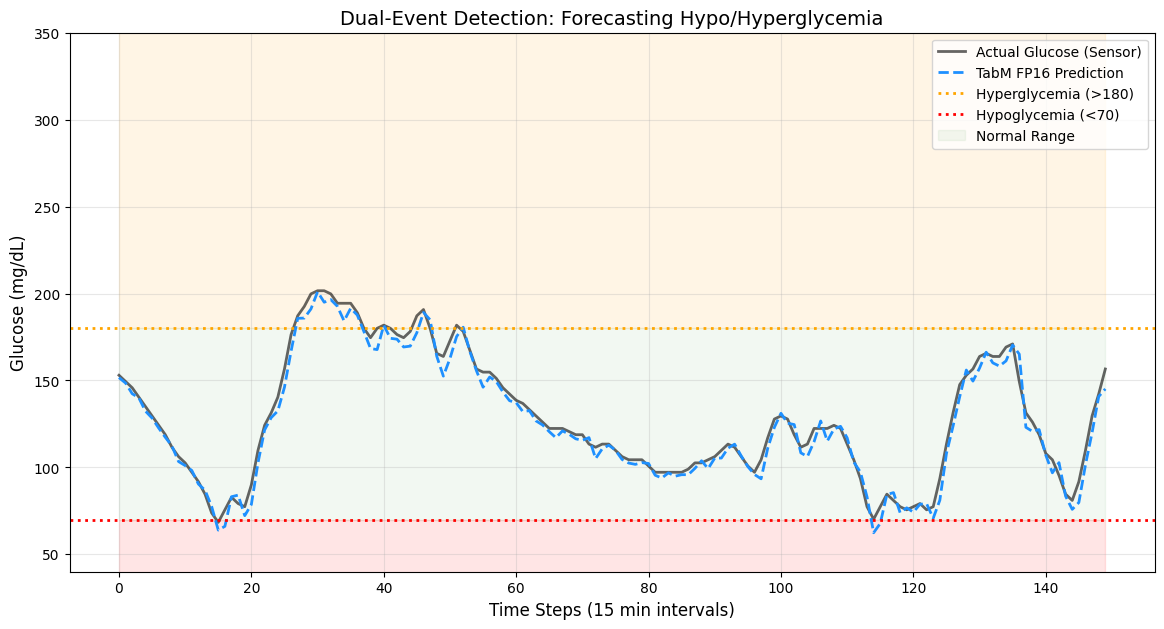

In [37]:
def visualize_final_result():
    print("\n--- PART 5: VISUAL PROOF (Dual-Detection Simulation) ---")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load Data & Model
    full_ds = DiabetesDataset(PROCESSED_DATA_PATH)
    
    # We need a chunk that shows both HIGH and LOW to prove the model works
    # Subject 1006 usually has high volatility. Let's try to find a dynamic range.
    # We scan for a segment with variance
    start_idx = 800 # Picking a later segment usually has more activity
    end_idx = start_idx + 150 # 1.5 Days
    
    sample_in, _ = full_ds[0]
    model = TabM_Regressor(input_dim=sample_in.shape[0], num_models=4).to(device)
    model.load_state_dict(torch.load(MODEL_PATH_FP16))
    model.half()
    model.eval()
    
    actuals, preds = [], []
    
    with torch.no_grad():
        for i in range(start_idx, end_idx):
            if i >= len(full_ds): break
            x, y = full_ds[i]
            x = x.unsqueeze(0).to(device).half()
            p = model(x)
            actuals.append(y.item())
            preds.append(p.item())
            
    # PLOTTING
    plt.figure(figsize=(14, 7))
    
    # 1. Reality vs AI
    plt.plot(actuals, label='Actual Glucose (Sensor)', color='black', linewidth=2, alpha=0.6)
    plt.plot(preds, label='TabM FP16 Prediction', color='dodgerblue', linestyle='--', linewidth=2)
    
    # 2. Danger Zones
    # Hyperglycemia (>180)
    plt.axhline(y=180, color='orange', linestyle=':', linewidth=2, label='Hyperglycemia (>180)')
    plt.fill_between(range(len(actuals)), 180, 400, color='orange', alpha=0.1)
    
    # Hypoglycemia (<70)
    plt.axhline(y=70, color='red', linestyle=':', linewidth=2, label='Hypoglycemia (<70)')
    plt.fill_between(range(len(actuals)), 0, 70, color='red', alpha=0.1)
    
    # 3. Normal Zone (Green tint optional, or just leave white)
    plt.fill_between(range(len(actuals)), 70, 180, color='green', alpha=0.05, label='Normal Range')

    plt.title("Dual-Event Detection: Forecasting Hypo/Hyperglycemia", fontsize=14)
    plt.xlabel("Time Steps (15 min intervals)", fontsize=12)
    plt.ylabel("Glucose (mg/dL)", fontsize=12)
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.ylim(40, 350) 
    plt.show()

visualize_final_result()